# 第一个神经网络

开放互评作业，这里记录一些设计过程。

目标：
1. 设计一个层数 $\geq 2$ 的神经网络（NN、MLP），处理识别 minist 手写数字图片。 $ \mathbb{R}^{n} \to \{0, 1, \ldots, 9\}$ 
2. 50k训练数据，图片大小 28x28 像素， 表示 0 ~ 9 的手写数字。 10k验证数据； 10k测试数据
3. 测试数据上accuracy至少95%，满分需要达到 98%以上。 画出 train loss和test loss曲线

/home/yangdong/Applications/miniconda3/envs/DL3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


(50000, 28, 28) (50000,)
digit 5


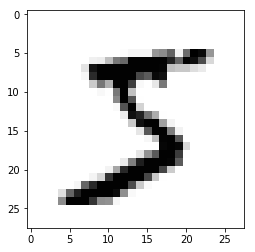

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

from preprocessed_mnist import load_dataset

X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()
print(X_train.shape, y_train.shape)
plt.imshow(X_train[0], cmap="Greys");
print('digit', y_train[0])

In [2]:
# size
n_input = X_train.shape[1] * X_train.shape[2]
n_classes = 10   # for simple

n_train = X_train.shape[0]
n_val = X_val.shape[0]
n_test = X_test.shape[0]

# reshape data
X_train2 = X_train.reshape(n_train, n_input)
X_val2 = X_val.reshape(n_val, n_input)
X_test2 = X_test.reshape(n_test, n_input)

# lables - one hot encoding
y_train2 = np.zeros((n_train, n_classes))
y_train2[np.arange(n_train), y_train] = 1
y_val2 = np.zeros((n_val, n_classes))
y_val2[np.arange(n_val), y_val] = 1
y_test2 = np.zeros((n_test, n_classes))
y_test2[np.arange(n_test), y_test] = 1


In [3]:
# Parameters
learning_rate = 0.1

# Network Parameters
n_hidden_1 = 256 # 1st layer number of neurons
n_hidden_2 = 50 # 2nd layer number of neurons
num_input = 784 # MNIST data input (img shape: 28*28)
num_classes = 10 # MNIST total classes (0-9 digits)

# # tf Graph input
# X = tf.placeholder("float", [None, num_input])
# Y = tf.placeholder("float", [None, num_classes])

# # Store layers weight & bias
# parameters = {
#     'W1': tf.Variable(tf.random_normal([n_input, n_hidden_1])),
#     'b1': tf.Variable(tf.random_normal([n_hidden_1])),
#     'W2': tf.Variable(tf.random_normal([n_hidden_1, n_hidden_2])),
#     'b2': tf.Variable(tf.random_normal([n_hidden_2])),
#     'W3': tf.Variable(tf.random_normal([n_hidden_2, n_classes])),
#     'b3': tf.Variable(tf.random_normal([n_classes]))
# }


X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])
dropout_keep_prob = tf.placeholder(tf.float32)

def create_nn_model(dims):
    layers = [X]
    layer = X
    L = len(dims) - 1
    for i in range(L - 1):  # hidden layers
        W = tf.Variable(tf.random_normal([dims[i], dims[i+1]], stddev=0.1))
        b = tf.Variable(tf.random_normal([dims[i+1]], stddev=0.1))
        layer = tf.nn.dropout(tf.nn.relu(tf.matmul(layer, W) + b), keep_prob=dropout_keep_prob)
        layers.append(layer)
    W = tf.Variable(tf.random_normal([dims[L-1], dims[L]]))
    b = tf.Variable(tf.random_normal([dims[L]]))
    logits = tf.matmul(layer, W) + b
    return logits
    
        

In [4]:
# Parameters
learning_rate = 0.1

# Construct model
logits = create_nn_model([n_input, 512, 128, n_classes])

# Define loss and optimizer
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
    logits=logits, labels=Y))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_op = optimizer.minimize(loss_op)

# Evaluate model (with test logits, for dropout to be disabled)
correct_pred = tf.equal(tf.argmax(logits, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))


In [5]:
epochs = 200
train_size = X_train2.shape[0]
batch_size = 2048
display_epoch = 10

train_loss = []
val_loss = []
# Start training
with tf.Session() as sess:
    # Run the initializer
    # Initialize the variables (i.e. assign their default value)
    init = tf.global_variables_initializer()
    sess.run(init)
    for epoch in range(epochs):
        perm = np.arange(train_size)
        np.random.shuffle(perm)
        for i in range(0, train_size, batch_size):
            randidx = perm[i:i+batch_size]
            batch_x = X_train2[randidx, :]
            batch_y = y_train2[randidx, :]
            # Run optimization op (backprop)
            sess.run(train_op, feed_dict={X: batch_x, Y: batch_y, dropout_keep_prob: 0.8})
        if epoch % display_epoch == 0 or epoch == 1:
            # Calculate batch loss and accuracy
            loss, acc = sess.run([loss_op, accuracy], feed_dict={X: batch_x, Y: batch_y, dropout_keep_prob: 1.})
            train_loss.append(loss)
            loss2, acc2 = sess.run([loss_op, accuracy], feed_dict={X: X_test2, Y: y_test2, dropout_keep_prob: 1.})
            val_loss.append(loss2)
            
            print("Epoch " + str(epoch) + ", Minibatch Loss= " + \
                  "{:.4f}".format(loss) + ", Training Acc= " + \
                  "{:.3f}".format(acc) + ", Test Acc= " + "{:.3f}".format(acc2))

    print("Optimization Finished!")

    # Calculate accuracy for MNIST test images
    print("Testing Accuracy:", \
        sess.run(accuracy, feed_dict={X: X_test2, Y: y_test2, dropout_keep_prob: 1.}))

Epoch 0, Minibatch Loss= 1.9385, Training Acc= 0.294, Test Acc= 0.325
Epoch 1, Minibatch Loss= 1.7768, Training Acc= 0.316, Test Acc= 0.355
Epoch 10, Minibatch Loss= 1.2596, Training Acc= 0.501, Test Acc= 0.484
Epoch 20, Minibatch Loss= 1.1977, Training Acc= 0.520, Test Acc= 0.531
Epoch 30, Minibatch Loss= 1.0514, Training Acc= 0.607, Test Acc= 0.598
Epoch 40, Minibatch Loss= 0.9760, Training Acc= 0.656, Test Acc= 0.645
Epoch 50, Minibatch Loss= 1.0216, Training Acc= 0.657, Test Acc= 0.659
Epoch 60, Minibatch Loss= 0.9258, Training Acc= 0.708, Test Acc= 0.725
Epoch 70, Minibatch Loss= 0.8512, Training Acc= 0.762, Test Acc= 0.737
Epoch 80, Minibatch Loss= 0.8377, Training Acc= 0.742, Test Acc= 0.737
Epoch 90, Minibatch Loss= 0.9003, Training Acc= 0.689, Test Acc= 0.712
Epoch 100, Minibatch Loss= 0.9072, Training Acc= 0.706, Test Acc= 0.701
Epoch 110, Minibatch Loss= 0.8835, Training Acc= 0.683, Test Acc= 0.642
Epoch 120, Minibatch Loss= 0.8890, Training Acc= 0.677, Test Acc= 0.676
Epoch


sigmoid, learning_rate =0.1, batch_size = 2048, hidden_units = 512, epochs = 35,   accuracy = 0.9589

training已经到极限了吧， 现在看一下泛化能力。与testing accuracy差距还是有点大。 

dropout_keep_prob = 0.9,  能提高 一些  0.9671
dropout_keep_prob = 0.8,  epochs = 50,  0.9699


尝试 加了一层 128，但是效果不怎么好。感觉是近了一些。 训练变慢
Epoch 47, Minibatch Loss= 0.1719, Training Accuracy= 0.959
Epoch 48, Minibatch Loss= 0.1620, Training Accuracy= 0.962
Epoch 49, Minibatch Loss= 0.1903, Training Accuracy= 0.954
Optimization Finished!
Testing Accuracy: 0.9452， 

3层，epochs = 100， keep_prob = 0.8， 最终得分： 0.91...

keep_prob = 0.8 使用relu单元， 最终是0.96 ， 与训练集相差还是大一些


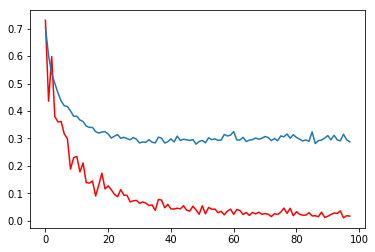

In [168]:
cut = 2
t = np.arange(len(train_loss)-cut)
plt.plot(t, train_loss[cut:], 'r-', t, val_loss[cut:], '-')
plt.show()

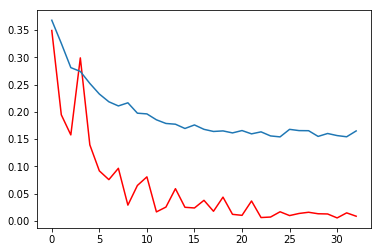

In [146]:
cut = 2
t = np.arange(len(train_loss)-cut)
plt.plot(t, train_loss[cut:], 'r-', t, val_loss[cut:], '-')
plt.show()

In [74]:
# hyperparamters
learning_rate = 0.01

# tf Graph input
X = tf.placeholder("float", [None, n_input])
Y = tf.placeholder("float", [None, n_classes])

# Hidden fully connected layer with 256 neurons
# layer_1 = tf.nn.relu(tf.add(tf.matmul(X, parameters['W1']), parameters['b1']))
# # Hidden fully connected layer with 256 neurons
# layer_2 = tf.nn.relu(tf.add(tf.matmul(layer_1, parameters['W2']), parameters['b2']))
# Output fully connected layer with a neuron for each class
# y_prediction = tf.nn.softmax(tf.add(tf.matmul(X, parameters['W1']), parameters['b1']))

# Hidden fully connected layer with 256 neurons
layer_1 = tf.nn.tanh(tf.matmul(X, parameters['W1']) + parameters['b1'])
# Hidden fully connected layer with 256 neurons
layer_2 = tf.nn.tanh(tf.matmul(layer_1, parameters['W2']) + parameters['b2'])
# Output fully connected layer with a neuron for each class
logits = tf.matmul(layer_2, parameters['W3']) + parameters['b3']

